### Continuous State Markov Chains

Here is my plan for learning Julia

1. Continuous Time Markov Chains

2. Numerical Linear Algebra and Factorizations
 
3. Krylov Methods and Matrix Conditioning

4. Discrete State Dynamic Programming

5. Markov Perfect Equilibrium

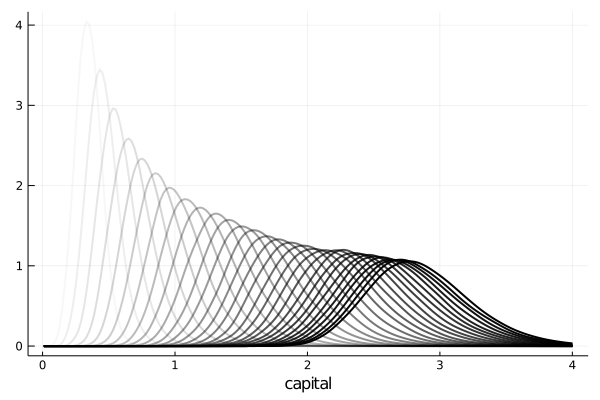

In [8]:
using Distributions, StatsPlots, Plots, QuantEcon, Random, LaTeXStrings
Random.seed!(42) # For deterministic results.


s = 0.2
δ = 0.1
a_σ = 0.4                    # A = exp(B) where B ~ N(0, a_σ)
α = 0.4                      # We set f(k) = k**α
ψ_0 = Beta(5.0, 5.0)         # Initial distribution
ϕ = LogNormal(0.0, a_σ)

function p(x, y)
    # Stochastic kernel for the growth model with Cobb-Douglas production.
    # Both x and y must be strictly positive.

    d = s * x.^α

    pdf_arg = clamp.((y .- (1-δ) .* x) ./ d, eps(), Inf)
    return pdf.(ϕ, pdf_arg) ./ d
end

n = 10000  # Number of observations at each date t
T = 30     # Compute density of k_t at 1,...,T+1

# Generate matrix s.t. t-th column is n observations of k_t
k = zeros(n, T)
A = rand!(ϕ, zeros(n, T))

# Draw first column from initial distribution
k[:, 1] = rand(ψ_0, n) ./ 2  # divide by 2 to match scale = 0.5 in py version
for t in 1:T-1
    k[:, t+1] = s*A[:, t] .* k[:, t].^α + (1-δ) .* k[:, t]
end

# Generate T instances of LAE using this data, one for each date t
laes = [LAE(p, k[:, t]) for t in T:-1:1]

# Plot
ygrid = range(0.01, 4, length = 200)
laes_plot = []
colors = []
for i in 1:T
    ψ = laes[i]
    push!(laes_plot, lae_est(ψ , ygrid))
    push!(colors,  RGBA(0, 0, 0, 1 - (i - 1)/T))
end
plot(ygrid, laes_plot, color = reshape(colors, 1, length(colors)), lw = 2,
     xlabel = "capital", legend = :none)


### Exercise 1

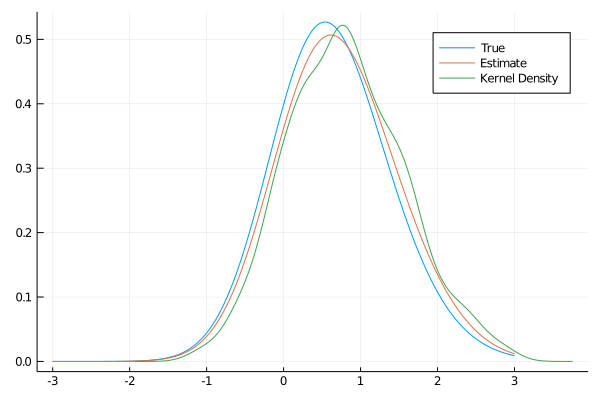

In [21]:
using KernelDensity 


n = 500
θ = 0.8
d  = sqrt((1.0 - θ^2))

p(x, y) = pdf.(Normal(), ((y .- θ .* abs.(x)) ./ d)) ./ d


ψ_true(y) = 2 .* pdf.(Normal(), y) .* cdf.(Normal(), θ * y ./ d) 

ζ = randn(n)
x = zeros(n)
for i in 1:n-1
    x[i+1] = θ * abs(x[i]) + d * ζ[i+1] 
end


ygrid = range(-3, 3, length = 200)
k_est = kde(x)

plot(ygrid, ψ_true(ygrid), label = "True")
plot!(ygrid, lae_est(LAE(p,x),ygrid), label = "Estimate")
plot!(k_est.x, k_est.density, label = "Kernel Density")


### Exercise 2

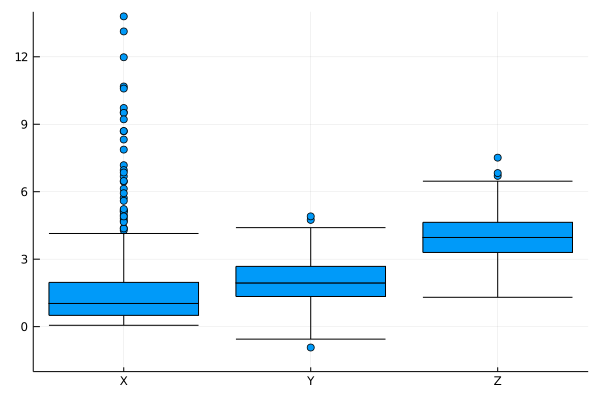

In [26]:
n = 500
x = randn(n)        # N(0, 1)
x = exp.(x)         # Map x to lognormal
y = randn(n) .+ 2.0  # N(2, 1)
z = randn(n) .+ 4.0  # N(4, 1)
data = vcat(x, y, z)
l = ["X" "Y" "Z"]
xlabels = reshape(repeat(l, n), 3n, 1)

boxplot(xlabels, data, label = "", ylims = (-2, 14))

  0.005827 seconds (7.19 k allocations: 1.446 MiB)


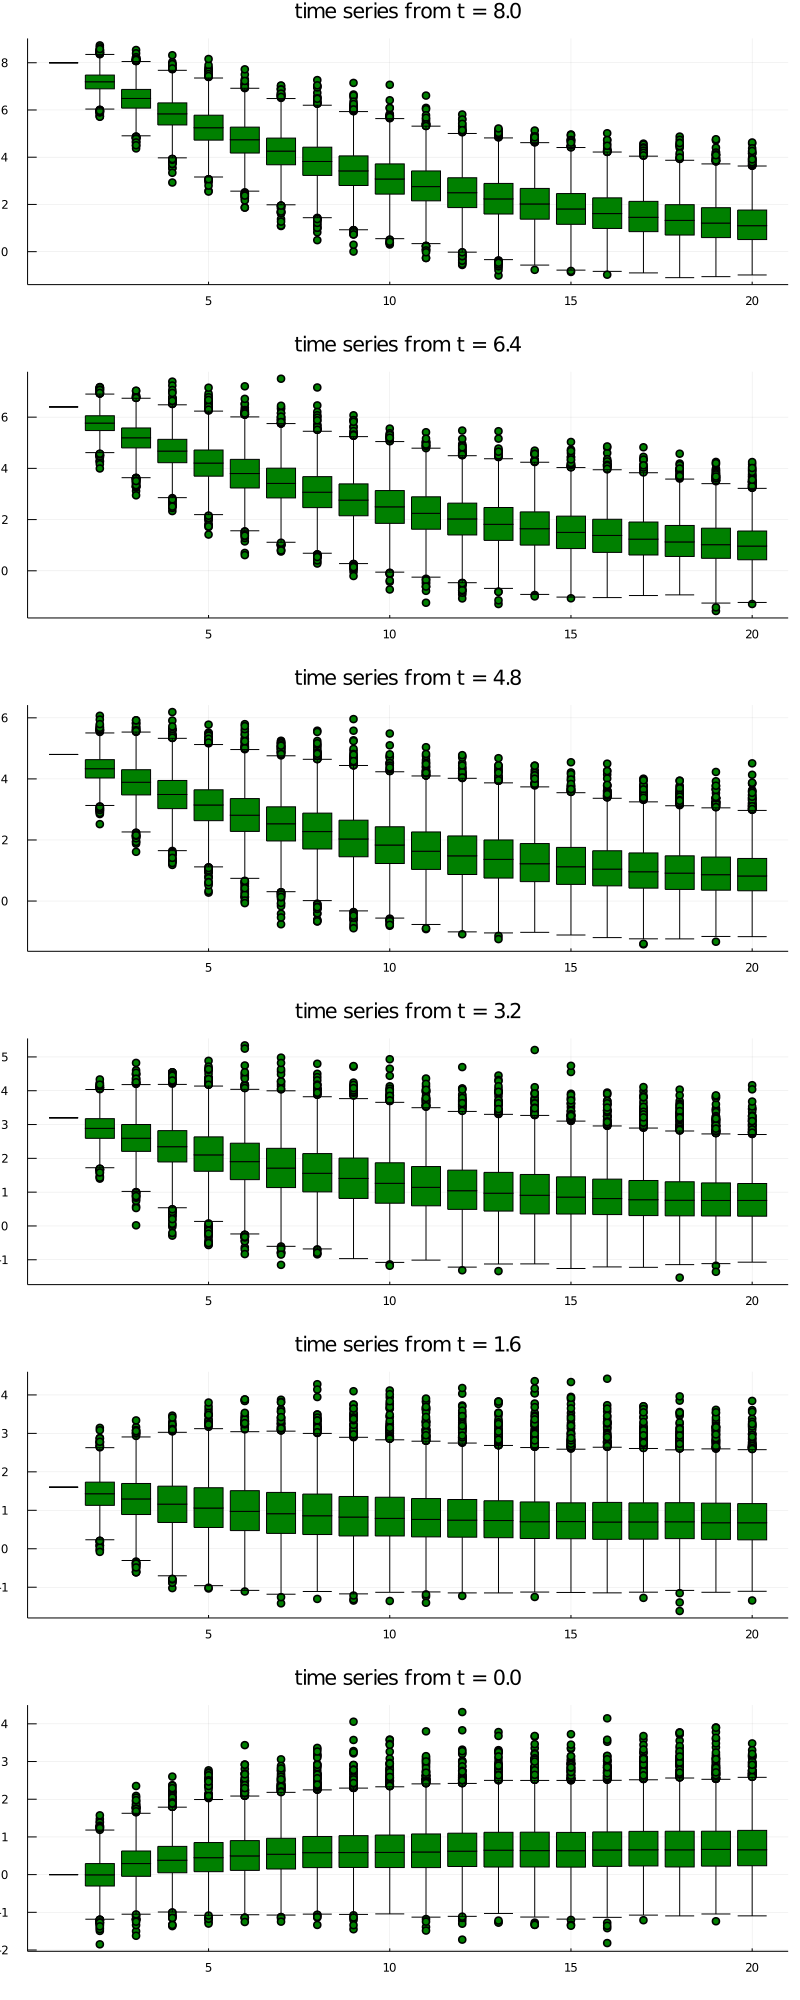

In [102]:
# J = 6 is used for the solution

n = 20
K = 5000
J = 6
θ = 0.9
d  = sqrt((1.0 - θ^2))

initial_conditions = range(8, 0, length = J)

plots = []
for j in 1:J
    data_j = zeros(K,n)
    for k in 1:K
        x = zeros(n)
        x[1] = initial_conditions[j]
        for t in 1:n-1
            x[t+1] = θ * abs(x[t]) + d * randn()
        end
        data_j[k,:] = x
    end
    push!(plots, boxplot(data_j, color = :green,
            title = "time series from t = $(initial_conditions[j])"))
end

@time plot(plots..., layout = (J, 1), legend = :none, size = (800, 2000))